# Tree species image classification using Artificial Neural Networks

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import os
import numpy as np
import matplotlib.pyplot as plt

## Getting the data

In [5]:
# DATA SET DIRECTORIES
local_path = "/home/sciapps/Documents/Repos/tfm"
source_dir = "data/images/image_preprocessing/processed_images_train_test/"
train_dir = os.path.join(local_path, source_dir, "train")
test_dir = os.path.join(local_path, source_dir, "test")

In [6]:
# LABELS
class_names = sorted(os.listdir(train_dir))
print(class_names)

['Acer_campestre', 'Alnus_glutinosa', 'Betula_pendula', 'Betula_pubescens', 'Buxus_sempervirens', 'Carpinus_betulus', 'Cornus_sanguinea', 'Corylus_avellana', 'Crataegus_laevigata', 'Crataegus_monogyna', 'Euonymus_europaea', 'Fagus_sylvatica', 'Frangula_alnus', 'Fraxinus_excelsior', 'Ilex_aquifolium', 'Juniperus_communis', 'Malus_sylvestris', 'Pinus_sylvestris', 'Populus_nigra', 'Populus_tremula', 'Prunus_avium', 'Prunus_padus', 'Prunus_spinosa', 'Quercus_petraea', 'Quercus_robur', 'Rhamnus_cathartica', 'Salix_caprea', 'Salix_cinerea_subsp._oleifolia', 'Salix_fragilis', 'Salix_pentandra', 'Salix_viminalis', 'Sambucus_nigra', 'Sorbus_aucuparia', 'Sorbus_rupicola', 'Sorbus_torminalis', 'Taxus_baccata', 'Tilia_cordata', 'Tilia_platyphyllos', 'Tilia_x_europaea', 'Ulmus_glabra', 'Ulmus_procera', 'Viburnum_opulus']


## Image decodification

`ImageDataGenrator`:

- Read images from the disk.
- Decode images in arrays of float pixel values (here RGB).
- Rescale the floats in the arrays from values between 0 and 255 to 0 and 1.
- Perform real-time image augmentation.

`flow_from_directory`:

- Generate the batches of array image data (aka tensors) with the real-time data augmentation defined in the `ImageDataGenerator`.
- Resize the arrays.

In [95]:
# CONFIGURATION ImageDataGenerator 
img_height = 300 
img_width = 300
color_mode= "rgb"
class_mode="categorical"                                  
shuffle=True                                                               
seed = 1234 

In [96]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Without augmentation

In [127]:
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)  
train_array_no_aug = train_datagen_no_aug.flow_from_directory(directory = train_dir,
                                            target_size=(img_width, img_height),
                                            color_mode = color_mode,
                                            shuffle = shuffle,
                                            class_mode = class_mode,
                                            subset = "training",
                                            seed=seed
                                            ) 

Found 565 images belonging to 42 classes.


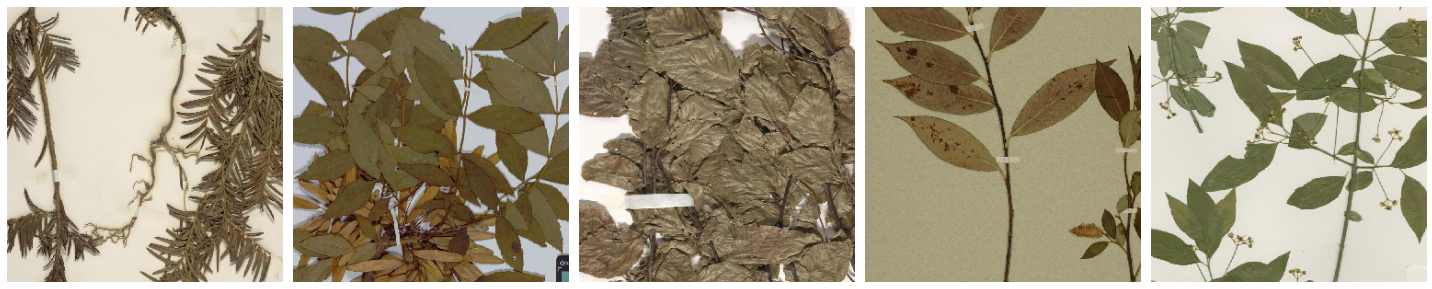

In [128]:
sample_training_images, _ = next(train_array_no_aug)
plot_images(sample_training_images[:5])


### Applying augmentation

Aim: increase the number of examples by randomly applying transformations to the original images. It also prevents overfitting of the model. 

Augmnetation methods applied:

- Rotation
- Vertica flip
- Horizontal flip

Other augmentation methods that were found not suitable (leave shape distorsion):
- Width shift 
- Height shift
- Zooming

In [129]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            validation_split = 0.20)  

In [130]:
train_array = train_datagen.flow_from_directory(directory = train_dir,
                                            target_size=(img_width, img_height),
                                            color_mode = color_mode,
                                            shuffle = shuffle,
                                            class_mode = class_mode,
                                            subset = "training",
                                            seed=seed
                                            ) 
validation_array = train_datagen.flow_from_directory(train_dir,  # same directory as training data
                                                    target_size=(img_width, img_height),
                                                    color_mode = color_mode,
                                                    #batch_size=batch_size,
                                                    class_mode= class_mode,
                                                    subset='validation',
                                                    seed=seed) # set as validation data 

Found 470 images belonging to 42 classes.
Found 95 images belonging to 42 classes.


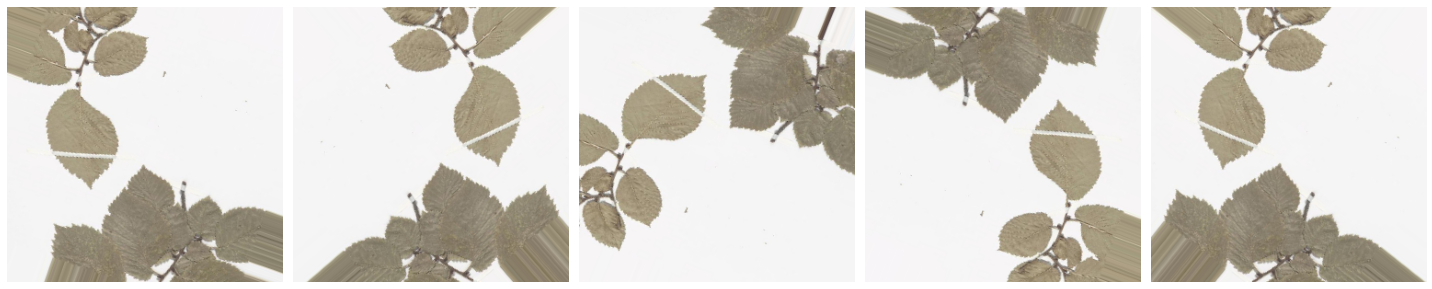

In [131]:
augmented_images = [train_array[8][0][0] for i in range(5)]
plot_images(augmented_images)

## Creating, training and evaluating the model

### Model network architecture

The simplest network architecture constists of 3 layers:
- Input layer, with a number of nodes equal to the number of features in the model.
- Hidden layer, with a variable number of nodes. 
- Output layer, with a number of nodes equal to the number of classes. 

#### The hidden layers

The hidden layers can have different characteristics depending of their use. 
For image classification, at least one of the hidden layers will be convolutional.

##### The convolutional layer

The main characteristic of a convolutional layer is that it applies a filter to each of the elements of a matrix (the pixels of an image). This filter is called the **kernel**. The kernel is a matrix (generally of small size, 2x3, 3x2, 3x3...) with a set of fixed real numbers. Each pixel of the original image is multiplied by the kernel matrix and the result sumed up to output another pixel value for the transformed image. Each time the filter is applied to all the pixels of an image is called a **convolution**.

At this level , the performance of the image feature extraction depends on the values in the kernel and the concatenation of convolutional layers. This is because different filters may be specialized in extracting different features (for example, vertical or horizontal edges) and the sequential input and output values for each layer improves the final output.

In keras, the convolutional layer applied to a 2D matrix is called `Conv2D`.

##### The fully connected layer

A fully connected layer is an all purpose layer where each node receive the inputs from all the nodes from the previous layer, multiplied by their weights, sumed and transformed by the activation funcion.

In keras, the fully connected layer is called `Dense`.



### Creating the model with `Keras`

In `Keras` the model is defined with the `Sequential` method as a linear stack ot layers. The **input layer** is implicit in the first layer (a network with 3 layers will have 2 in `keras Sequential` method).

The **input shape** is into the first layer. The model inputs are the tensors or arrays. Images have 3 dimensions: **width**, **height** and **channels**. The width and the height are measured in pixels and the channels reference the color values (the channel value is 1 if it is in black and white and 3 if it is color in RGB (Red, Green, blue) or HSV (hue, saturation, value) formats - 2 and 4 are black and white or color with an alpha channel (transparency). 

The **activation function** that has to be specified in each layer transforms the input data so that the output doen't have a linear relation with the input. 

Ty
the number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64).
    ## Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer
    # For each example the model returns a vector of "logits" or "log-odds" scores, one for each class.
    # The tf.nn.softmax function converts these logits to "probabilities" for each class

#### Layer parameters

In [35]:
# MODEL PARAMETERS

# First layer
channels = 3
input_shape = (img_width, img_height, channels)
print(input_shape)

## Conv2D layer
#filters = 
kernel_size = (3,3) 
padding = "same" # case insensitive. Other option: "valid"
data_format = "channels_last"

## Dense layer
array_size = img_width*img_height
dense_size = 10 
num_classes = len(class_names)

(300, 300, 3)


In [36]:
# MODEL ARCHITECTURE
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16,3, padding = padding, activation = "relu", 
                                data_format = data_format, input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32,3, padding = padding, activation = "softmax"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation = "softmax")) # last layer
model.build()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 32)      4640      
_________________________________________________________________
flatten (Flatten)            (None, 2880000)           0         
_________________________________________________________________
dense (Dense)                (None, 42)                120960042 
Total params: 120,965,130
Trainable params: 120,965,130
Non-trainable params: 0
_________________________________________________________________


### Training the model

The parameters from the model above represent the **weights**. 
A weight is a number that multiplies the value of the **input node** before passing it to the **output node** in the next layer. 
An output node receive the values from each of the input nodes multiplied by their weights, after they have been sumed and transformed by the **activation function**.


Training the model means to adjust the values of the weights in the subsequent runs (the **epochs**. In every run, the weights are modified based on an optimization algorithm or **optimizer**.
This algorithm tries to minimize the **loss function**. In every run, the model predicts the classes with a certain probability. The loss function measures, through that probability, the error of the predictions. In this context, the **gradient** is the computation of the error in relation to the weight (it is the derivative of the error divided into the derivative of the weight). The gradient is multiplied by a **learning rate** to obtain the new weights. The value of the learning rate is in the order of 10^-3.

**Stocastic gradient descent** (sgd) is one type of optimizer. There are also different types of loss functions, like the **sparse categorical crossentropy**. The value of the optimizer 

#### Configuration

- Epoch: the number of iterations through the network in order to adjust the weights. In general, the higher number of epochs, the better the performance, up to a limit. 
- Batch size: the number of examples passed at a time. If the batch size is equal to the number of examples in the training dataset, then we have one batch per epoch. This is computationally costly and may be limited by the machine power. If the batch size is smaller, then there would be several runs per epoch. If it is too small, the training may be too slow.  

In [37]:
batch_size = round(len(train_array)/4)
epochs = 30  

In [38]:
# COMPILING THE MODEL
# SparseCategoricalCrossentropi directly uses classes labels,
## so that they don't need to be numerically encoded.
optimizer = "sgd" # Options: "sgd", "adam"
model.compile(optimizer=optimizer,
            loss = "categorical_crossentropy",
            metrics=['accuracy'])

model.fit(train_array,
          class_names,
          batch_size = 10,
          epoch = 20,
          shuffle = True,
          verbose = 2)

In [41]:
# TRAINING THE MODEL
history = model.fit_generator(
    train_array,
    batch_size = batch_size
    #steps_per_epoch= len(train_array) / epochs
    epochs=epochs,
    verbose=1, # get a progress bar and ETA
    validation_data=validation_array,
    validation_steps=2 # batch_size
)

Epoch 1/5
15/15 [==============================] - 129s 9s/step - loss: 4.1385 - acc: 0.0191 - val_loss: 4.7240 - val_acc: 0.0312
Epoch 2/5
15/15 [==============================] - 124s 8s/step - loss: 4.4046 - acc: 0.0213 - val_loss: 4.3932 - val_acc: 0.0156
Epoch 3/5
15/15 [==============================] - 121s 8s/step - loss: 4.3871 - acc: 0.0255 - val_loss: 4.9049 - val_acc: 0.0469
Epoch 4/5
15/15 [==============================] - 150s 10s/step - loss: 4.5100 - acc: 0.0277 - val_loss: 4.6563 - val_acc: 0.0469
Epoch 5/5
15/15 [==============================] - 136s 9s/step - loss: 4.3357 - acc: 0.0596 - val_loss: 4.2635 - val_acc: 0.0312


### Evaluating the model

#### Accuracy and loss during training

In [42]:
# Parameters measured during model training
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [46]:
acc = history_dict["acc"]
val_acc = history_dict["val_acc"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs_range = range(epochs)

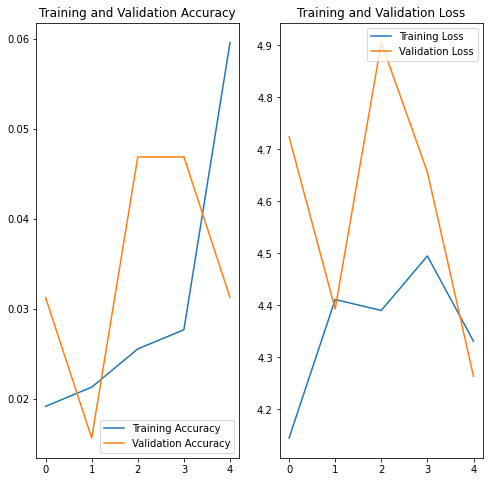

In [47]:
plt.figure(figsize=(8, 8))
# Accuracy plots
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss plots
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss') 
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Overfitting

When the model predicts significantly better the training set than the validation set, it is a sign of overfitting. 